In [1]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from hw6_utils import *

In [2]:
def make_absolute_G_mags(df,u_abs = False):
    """
    Calculate the absolute G magnitudes of the stars in the dataframe.
    Parameters:
    - df: Pandas DataFrame containing the Gaia stars.

    Returns:
    - df: Pandas DataFrame with the absolute G magnitudes added.   
    
    """
    df['G_abs'] = df['phot_g_mean_mag'] - 5 * np.log10(1000/df['parallax']) + 5

    if u_abs:
        df['U_abs'] = df['u'] - 5 * np.log10(1000/(df['parallax'] + df['parallax_error'])) + 5

    return df

In [3]:
df_gaia = query_stars(load=True)
df = df_gaia.copy()
df = make_absolute_G_mags(df)

In [4]:
df

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,G_abs
0,0,1636148068921376768,Gaia DR3 1451503404777191936,1451503404777191936,415220063,2016.0,207.153819,0.360702,27.196561,0.279023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.073094
1,1,1636148068921376768,Gaia DR3 1319008066039151744,1319008066039151744,78822269,2016.0,244.886421,0.389389,30.449667,0.447656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.010611
2,2,1636148068921376768,Gaia DR3 4050943987628929792,4050943987628929792,479317220,2016.0,272.469069,0.811179,-27.922945,0.534769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.069169
3,3,1636148068921376768,Gaia DR3 5972194051369608064,5972194051369608064,1270097524,2016.0,258.063140,0.446958,-39.531496,0.270517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.408221
4,4,1636148068921376768,Gaia DR3 4123603568470516352,4123603568470516352,50208071,2016.0,264.458296,1.251677,-17.089808,1.063817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.916831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297416,297416,1636148068921376768,Gaia DR3 4472832130942575872,4472832130942575872,1329945144,2016.0,269.448503,0.026239,4.739420,0.029044,...,0.0,0.0005,0.0,0.0,0.0003,0.0,0.0,0.0002,MARCS,11.883816
297417,297417,1636148068921376768,Gaia DR3 385334230892516480,385334230892516480,1683081142,2016.0,4.613226,0.014406,44.024787,0.010101,...,0.0,0.0005,0.0,0.0,0.0003,0.0,0.0,0.0002,MARCS,9.459832
297418,297418,1636148068921376768,Gaia DR3 4810594479418041856,4810594479418041856,514472228,2016.0,77.959937,0.015059,-45.043813,0.016368,...,0.0,0.0005,0.0,0.0,0.0004,0.0,0.0,0.0002,MARCS,10.089418
297419,297419,1636148068921376768,Gaia DR3 6553614253923452800,6553614253923452800,785951967,2016.0,346.503917,0.017067,-35.847164,0.014151,...,0.0,0.0003,0.0,0.0,0.0002,0.0,0.0,0.0001,PHOENIX,8.937367


In [5]:
# Plot color-magnitude diagram
points = {
    'p0': (-1,5),
    'p1': (1,13),
    'p2': (2,17.5),
    'p3': (3,20),
    'p4': (4,22),
}

def make_line_seg(points):
    sorted_keys = sorted(points.keys(), key=lambda p: float(p[1:]))  # Ensure correct order
    line_seg = [(points[sorted_keys[i]], points[sorted_keys[i+1]]) for i in range(len(sorted_keys) - 1)]
    return line_seg

line_seg = make_line_seg(points)


In [6]:
def process_ug_df(df):
    df_new = df.copy()
    df_new.loc[:,'u-g'] = df_new['u'] - df_new['g'] 
    df_new.loc[:,'bp_rp'] = df_new['phot_bp_mean_mag'] - df_new['phot_rp_mean_mag']

    df_new = make_absolute_G_mags(df_new, u_abs=True) 

    return df_new

Number of outliers: 16396


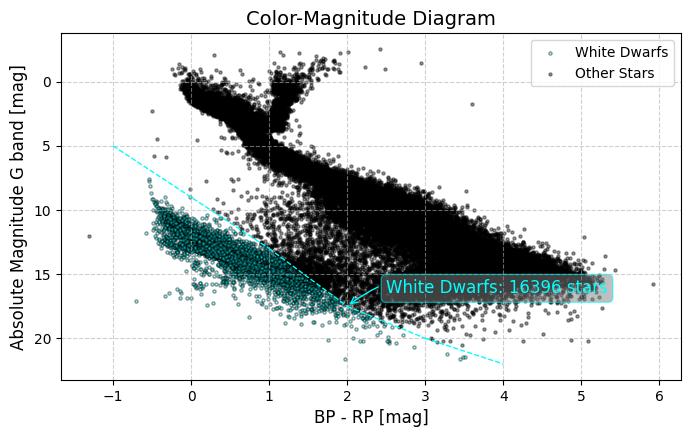

,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,G_abs
0,0,1636148068921376768,Gaia DR3 1451503404777191936,1451503404777191936,415220063,2016.0,207.153819,0.360702,27.196561,0.279023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.073094
2,2,1636148068921376768,Gaia DR3 4050943987628929792,4050943987628929792,479317220,2016.0,272.469069,0.811179,-27.922945,0.534769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.069169
4,4,1636148068921376768,Gaia DR3 4123603568470516352,4123603568470516352,50208071,2016.0,264.458296,1.251677,-17.089808,1.063817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.916831
9,9,1636148068921376768,Gaia DR3 1918778533569328256,1918778533569328256,384104544,2016.0,354.783317,0.420160,37.482646,0.272442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.297870
11,11,1636148068921376768,Gaia DR3 6030333717995526144,6030333717995526144,1706706401,2016.0,250.434059,1.081337,-32.461776,0.642939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.840803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297400,297400,1636148068921376768,Gaia DR3 4698424845771339520,4698424845771339520,1087897205,2016.0,25.750304,0.010807,-67.312958,0.009853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.758799
297410,297410,1636148068921376768,Gaia DR3 5273943488410008832,5273943488410008832,821697039,2016.0,118.301184,0.011445,-67.798672,0.011561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.216653
297411,297411,1636148068921376768,Gaia DR3 5332606522595645952,5332606522595645952,778663322,2016.0,176.456647,0.013777,-64.843053,0.015098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.092106
297413,297413,1636148068921376768,Gaia DR3 2552928187080872832,2552928187080872832,1160313233,2016.0,12.296740,0.016581,5.376557,0.008281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.124543


In [7]:
plot_color_magnitude_diagram(df, line_segments=line_seg, boring_plot=False,mag_ug=False)

In [8]:
sdss_df = query_sdss_xmatch(load=True)
df_temp = sdss_df.copy()
df_temp = process_ug_df(df_temp)
df_temp = make_absolute_G_mags(df_temp)

final_df = df_temp[(df_temp['u'] >-50) & (df_temp['u-g'] <100)]


In [9]:
final_df.head()

,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_error,objid,u,g,r,i,z,u-g,bp_rp,G_abs,U_abs
0,9.981492,10.466039,9.336716,10.967355,0.036335,1237662981572330020,15.37119,14.05626,13.14883,12.19866,12.72760,1.31493,1.129323,5.182001,10.578882
1,17.469687,19.426530,16.167704,10.019123,0.091845,1237668573626108662,23.37180,20.11458,18.47906,16.74483,15.82025,3.25722,3.258826,12.473836,18.395764
2,13.719134,15.162105,12.543299,19.049086,0.016128,1237668573625975613,18.24972,15.73283,14.32499,13.00813,12.32557,2.51689,2.618806,10.118505,14.650928
3,14.666202,16.198835,13.455311,11.034884,0.036990,1237668573626042712,19.27417,16.82238,15.36163,13.95735,13.21826,2.45179,2.743524,9.880041,14.495276
4,13.490684,14.752601,12.297461,14.881135,0.075285,1237668573626041200,17.50990,15.50928,12.94487,13.86971,12.81478,2.00062,2.455140,9.353864,13.384038


Number of outliers: 5352


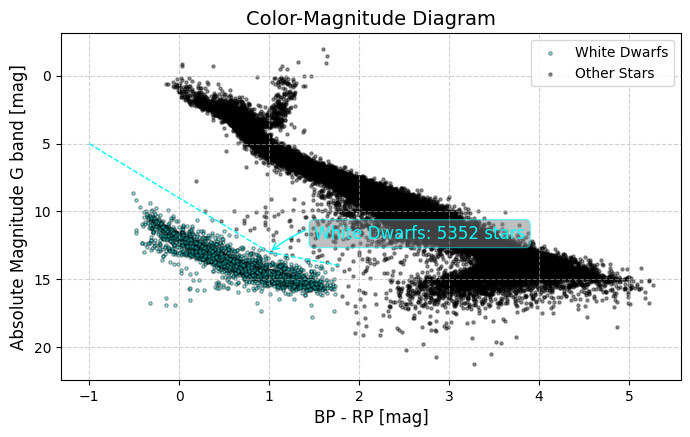

In [10]:
y_offset = 0

# Plot color-magnitude diagram
points = {
    'p0': (-1,5+y_offset),
    'p1': (1,13+y_offset),
    'p2': (1.8,14+y_offset),
}

line_seg= make_line_seg(points=points)
wd_sample = plot_color_magnitude_diagram(final_df, line_segments=line_seg, boring_plot=False,mag_ug=False)

In [11]:
# y_offset = 0

# # Plot color-magnitude diagram
# points_ug = {
#     'p0': (-1,5+y_offset),
#     'p1': (1,13+y_offset),
#     'p2': (1.8,14+y_offset),
# }

# line_seg_ug= make_line_seg(points=points_ug)
# wd_sample_ug = plot_color_magnitude_diagram(final_df, line_segments=None, boring_plot=True,mag_ug=True)

In [12]:
# plot_color_magnitude_diagram(wd_sample, line_segments=None, boring_plot=True,mag_ug=False,save_file='wd_sample_gbprp_CMD.png')

In [13]:
# U vs u-g
#plot_color_magnitude_diagram(wd_sample, line_segments=None, boring_plot=True,mag_ug=True,save_file='wd_sample_ug_CMD.png')

In [14]:
spectra_wd_df = pd.read_csv('SDSS_WDs.csv')

In [15]:
working_df = pd.merge(wd_sample, spectra_wd_df, left_on='objid', right_on='OBJID', how='inner')

In [16]:
wd_DA = working_df[working_df['SPECTYPE'] == 'DA']
wd_DB = working_df[working_df['SPECTYPE'] == 'DB']
wd_DQ = working_df[working_df['SPECTYPE'] == 'DQ']

print(f'Number of DA white dwarfs: {len(wd_DA)}')

print(f'Number of DB white dwarfs: {len(wd_DB)}')

print(f'Number of DQ white dwarfs: {len(wd_DQ)}')

Number of DA white dwarfs: 442
Number of DB white dwarfs: 6
Number of DQ white dwarfs: 26


In [17]:
# Spectral type masks
mask_DA = working_df['SPECTYPE'] == 'DA'
mask_DB = working_df['SPECTYPE'] == 'DB'
mask_DQ = working_df['SPECTYPE'] == 'DQ'

mask_list = [mask_DA, mask_DB, mask_DQ]

Number of pixels: 0.9


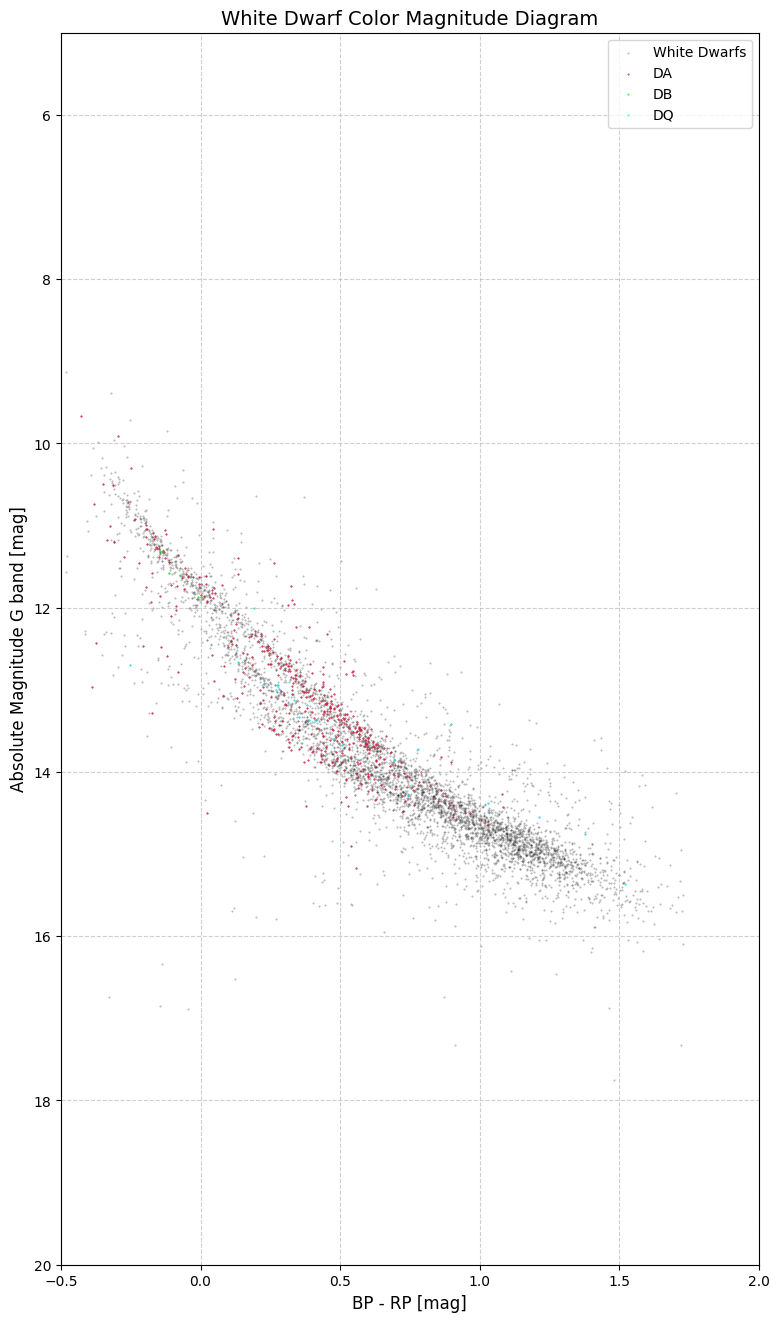

In [18]:
# Make it so one scatter point is 1 pixel
dpi = 800
num_pixels = 10
point_size = num_pixels * 72 / dpi

print(f'Number of pixels: {point_size}')


plot_wd_cmd(wd_sample,working_df,mask_list=mask_list,
            save_file='wd_cmd_masks.png',ssize=(point_size**2),marker='.')

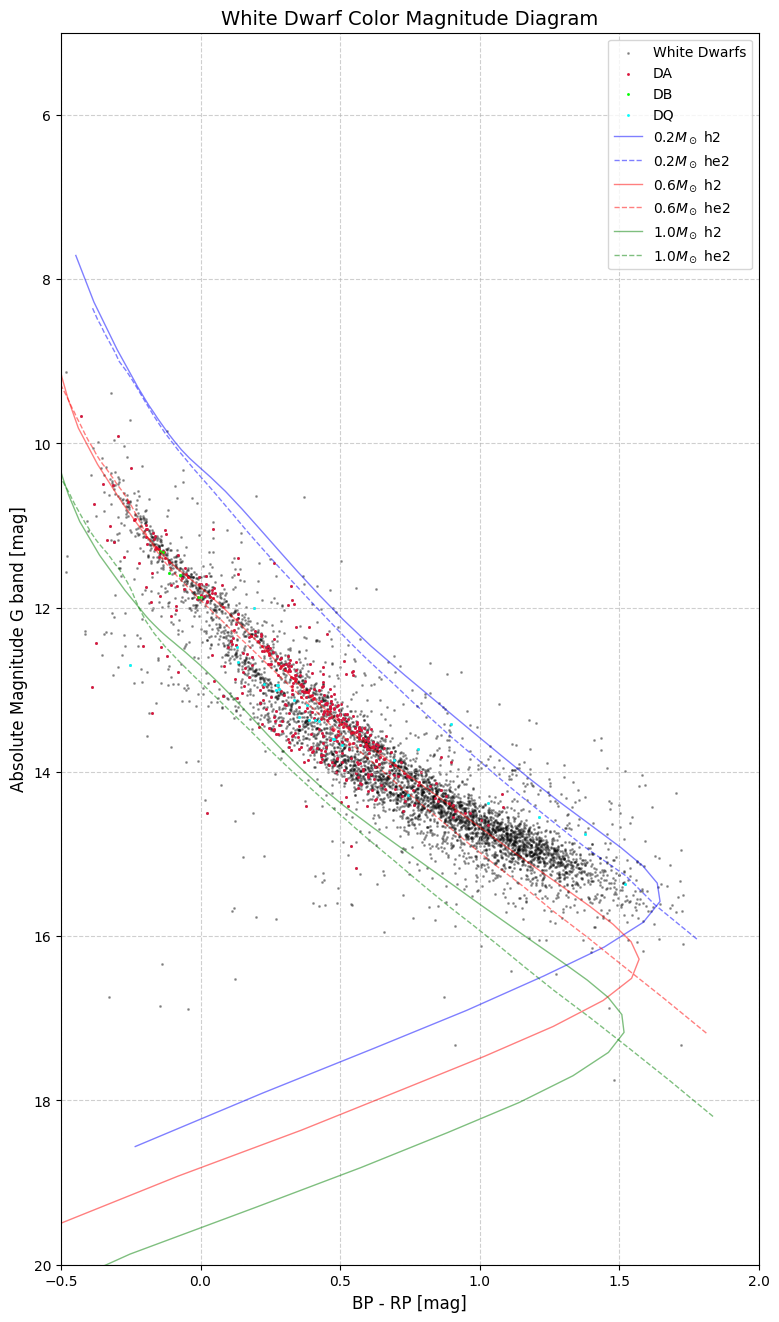

In [19]:
# Make a dictrionary to store the models
models = {}

# Get the models
for mass_str in ['0.2','0.6','1.0']:
    df_h2,df_he2 = get_mass_dfs(mass_str)
    models[mass_str] = df_h2,df_he2

plot_wd_cmd(df_wd=wd_sample,df_spec=working_df,time_gridding=False,
            mask_list=mask_list,models=models,save_file=
            'mass_models.png')

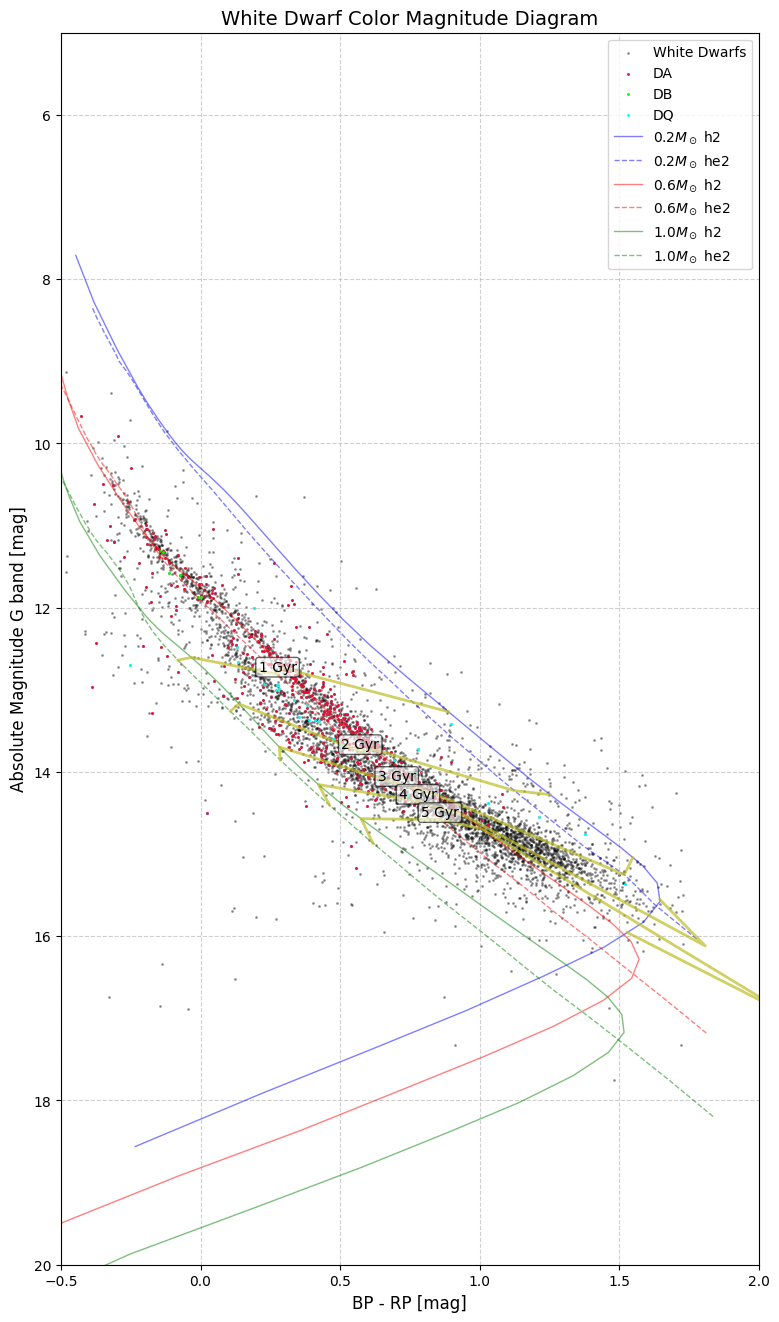

In [20]:
plot_wd_cmd(df_wd=wd_sample,df_spec=working_df,time_gridding=True,
            mask_list=mask_list,models=models,save_file=
            'mass_models.png',num_grids=5)

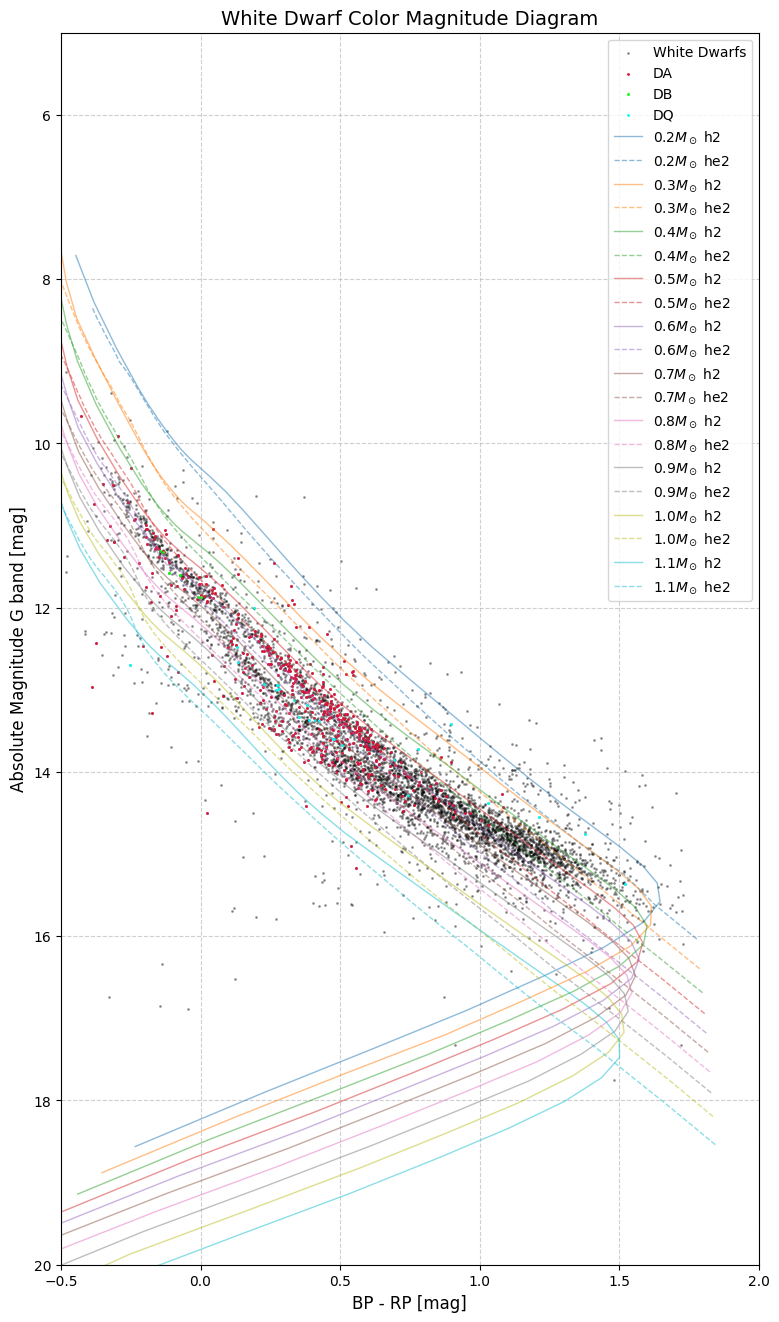

In [26]:
# Make a dictrionary to store the models
more_models = {}

for i in np.arange(0.2,1.2,0.1):
    mass_str = f'{i:.1f}'
    df_h2,df_he2 = get_mass_dfs(mass_str)
    more_models[mass_str] = df_h2,df_he2

# Make a list of model colors
import matplotlib.cm as cm
colors = cm.tab10(np.linspace(0,1,len(more_models)))

model_plot_params = {
                        'ms':5,
                        'lw':1,
                        'mc':colors,
                        'mstyles':['-','--'],
                        'mt_labels':['h2','he2']}


plot_wd_cmd(df_wd=wd_sample,df_spec=working_df,time_gridding=False,
            mask_list=mask_list,models=more_models,save_file=
            'mass_models.png',num_grids=5,model_plot_params=model_plot_params)

In [25]:
df_h2.columns

Index(['Teff', 'log_g', 'Mbol', 'BC', 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'Ks',
       'Y', 'J.1', 'H.1', 'K', 'W1', 'W2', 'W3', 'W4', 'S3.6', 'S4.5', 'S5.8',
       'S8.0', 'u', 'g', 'r', 'i', 'z', 'g.1', 'r.1', 'i.1', 'z.1', 'y', 'G2',
       'G2_BP', 'G2_RP', 'G3', 'G3_BP', 'G3_RP', 'FUV', 'NUV', 'Age', 'bp_rp',
       'G_abs'],
      dtype='object')

In [34]:
from scipy.interpolate import LinearNDInterpolator

def estimate_wd_masses(df, model_dict):
    """
    Estimate white dwarf masses based on BP-RP and Absolute G Magnitude.

    Parameters:
    - WD_df (pd.DataFrame): Observed white dwarfs with 'bp_rp' and 'G_abs'.
    - model_dict (dict): Dictionary where keys are mass strings (e.g., '0.2') and 
                         values are tuples (df_h2, df_he2), each containing 'bp_rp' and 'G_abs'.

    Returns:
    - WD_df (pd.DataFrame): Updated with estimated mass column.
    """
    WD_df = df.copy()
    
    model_data = []
    
    for mass_str, (df_h2, df_he2) in model_dict.items():
        mass = float(mass_str)  
        
        for model_df in [df_h2, df_he2]:  
            temp_df = model_df.copy()
            temp_df['Mass'] = mass  
            model_data.append(temp_df)

    model_df = pd.concat(model_data, ignore_index=True)

    interpolator = LinearNDInterpolator(list(zip(model_df['bp_rp'], model_df['G_abs'])), model_df['Mass'])

    WD_df.loc[:,'Estimated_Mass'] = interpolator(WD_df['bp_rp'], WD_df['G_abs'])

    return WD_df


In [35]:
WD_df = estimate_wd_masses(wd_sample, more_models)

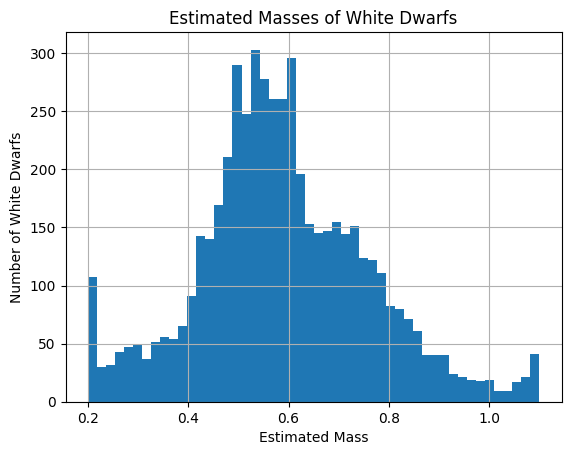

In [36]:
# Make a histogram of the estimated masses
WD_df['Estimated_Mass'].hist(bins=50)
plt.xlabel('Estimated Mass')
plt.ylabel('Number of White Dwarfs')
plt.title('Estimated Masses of White Dwarfs')
plt.savefig('estimated_masses.png')
plt.show()